In [ ]:
%load_ext autoreload
%autoreload 2

import itertools
from typing import Any, Callable, Iterable

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tqdm
import torch
import triton

import bench

matplotlib.rcParams.update({"axes.spines.right": False, "axes.spines.top": False, "legend.frameon": False})


def generate_configs(_filter: Callable[..., bool] | None = None, **axes: list[Any]) -> Iterable[triton.Config]:
    for values in itertools.product(*axes.values()):
        d = dict(zip(axes.keys(), values))
        if _filter is not None and not _filter(d):
            continue  # skip
        args = dict(kwargs=d)
        if "num_stages" in d:
            args["num_stages"] = d.pop("num_stages")
        if "num_warps" in d:
            args["num_warps"] = d.pop("num_warps")
        yield triton.Config(**args)


def sweep_benchmarks(benchmark: bench.Benchmark,
                     kernel: triton.runtime.Autotuner,
                     configs: Iterable[triton.Config],
                     settings: Iterable[bench.Settings]) -> Iterable[dict[str, Any]]:
    original_configs = kernel.configs
    try:
        # Settings > Config gives better results than Config > Settings
        progress = tqdm.tqdm(list(itertools.product(settings, configs)))
        for s, config in progress:
            try:
                progress.set_postfix_str(f"{s.__dict__} {config.all_kwargs()}")
                kernel.configs = [config]
                result = benchmark.run(s)
                yield {**s.__dict__, **config.all_kwargs(), **result.__dict__}
            except (triton.runtime.errors.OutOfResources, bench.UnsupportedSettings):
                pass
    finally:
        kernel.configs = original_configs


def sweep_benchmarks_df(*args, **kwargs) -> pd.DataFrame:
    df = pd.DataFrame.from_records(sweep_benchmarks(*args, **kwargs))
    df["gb_s"] = df["bytes_rw"] / df["time_s"] / 1e9
    df["tflops"] = df["ops"] / df["time_s"] / 1e12
    return df

model_dims = [3072, 4096, 6144, 8192]
batch_sizes = [16, 64, 256]
bits_range = [1, 2, 4, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## `mv`

In [63]:
df = sweep_benchmarks_df(
    bench.BENCHMARKS["mv"], bench.kernel__mv,
    configs=generate_configs(
        BLOCK_SIZE=[256, 512, 1024, 2048, 4096, 8192],
        num_stages=[1, 2, 3],
        num_warps=[1, 2, 4, 8, 16],
    ),
    settings=[
        bench.Settings(1, dim, dim, g=64, bits=16, copies=100, reps=100)
        for dim in model_dims
    ],
)

  0%|          | 0/360 [00:00<?, ?it/s]

100%|██████████| 360/360 [00:13<00:00, 26.96it/s]


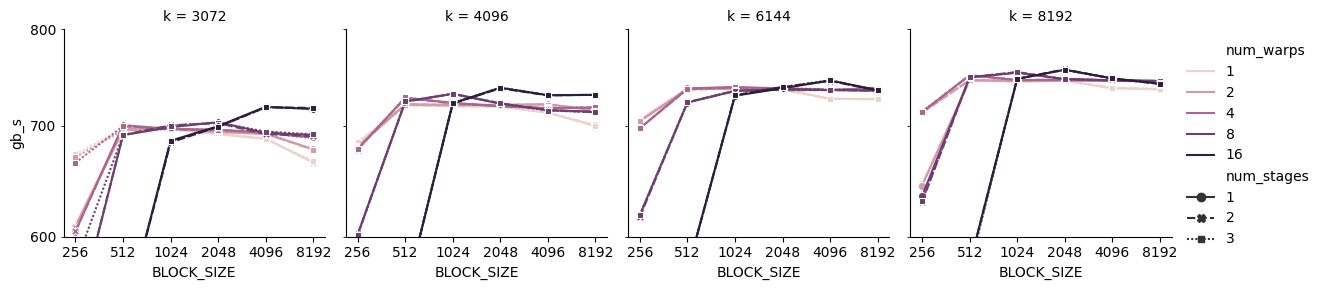

In [64]:
g = sns.relplot(data=df, y="gb_s", col="k", x="BLOCK_SIZE", hue="num_warps", style="num_stages",
                hue_norm=matplotlib.colors.LogNorm(), kind="line", markers=True, height=3)
for ax in g.axes.flatten():
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter("{x:.0f}")
    ax.yaxis.set_minor_formatter("{x:.0f}")
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.set_ylim((600, 800))

## `mm`

In [41]:
block_sizes = [16, 32, 64, 128, 256, 512]
df = sweep_benchmarks_df(
    bench.BENCHMARKS["mm"], bench.kernel__mm,
    configs=generate_configs(
        BLOCK_SIZE_M=block_sizes,
        BLOCK_SIZE_N=block_sizes,
        BLOCK_SIZE_K=block_sizes,
        GROUP_SIZE_M=[8],  # low impact
        num_stages=[3],  # consistently best
        num_warps=[1, 2, 4, 8],
        # large blocks are too slow to compile
        _filter=lambda c: c["BLOCK_SIZE_M"] * c["BLOCK_SIZE_N"] * c["BLOCK_SIZE_K"] <= 2**17,
    ),
    settings=[
        bench.Settings(m, dim, dim, g=64, bits=16, copies=100, reps=100)
        for m in batch_sizes
        for dim in model_dims
    ],
)

  0%|          | 0/2688 [00:00<?, ?it/s, {'m': 16, 'k': 3072, 'n': 3072, 'g': 64, 'copies': 100, 'reps': 100} {'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 16, 'BLOCK_SIZE_K': 16, 'GROUP_SIZE_M': 8, 'num_warps': 2, 'num_ctas': 1, 'num_stages': 3}]

100%|██████████| 2688/2688 [03:19<00:00, 13.44it/s, {'m': 256, 'k': 8192, 'n': 8192, 'g': 64, 'copies': 100, 'reps': 100} {'BLOCK_SIZE_M': 512, 'BLOCK_SIZE_N': 16, 'BLOCK_SIZE_K': 16, 'GROUP_SIZE_M': 8, 'num_warps': 8, 'num_ctas': 1, 'num_stages': 3}]


In [53]:
# for _, g in df.groupby(["m", "k"]):
#     display(g.sort_values(by="tflops", ascending=False).head(10).drop(
#         columns=["n", "g", "copies", "reps", "num_ctas", "name", "bytes_rw", "ops", "GROUP_SIZE_M", "num_stages", "time_s"]
#     ).style.hide())

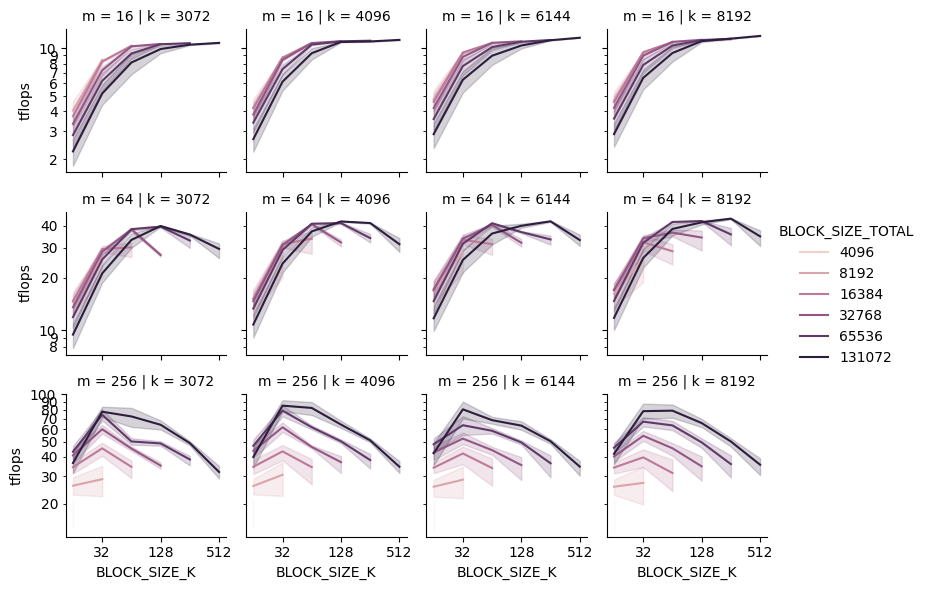

In [57]:
g = sns.relplot(data=df.pipe(lambda d: d.assign(BLOCK_SIZE_TOTAL=d["BLOCK_SIZE_M"] * d["BLOCK_SIZE_N"] * d["BLOCK_SIZE_K"])),
                y="tflops", row="m", col="k", x="BLOCK_SIZE_K", hue="BLOCK_SIZE_TOTAL",
                hue_norm=matplotlib.colors.LogNorm(), kind="line", markers=True, height=2,
                facet_kws=dict(sharey="row"))
for ax in g.axes.flatten():
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter("{x:.0f}")
    ax.yaxis.set_minor_formatter("{x:.0f}")
    ax.xaxis.set_major_formatter("{x:.0f}")

## `mv_lut8`

In [36]:
df = sweep_benchmarks_df(
    bench.BENCHMARKS["mv_lut8"], bench.kernel__mv_lut8,
    configs=generate_configs(
        BLOCK_SIZE=[128, 256, 512, 1024, 2048, 4096],
        num_stages=[1, 3],
        num_warps=[1, 2, 4, 8],
    ),
    settings=[
        bench.Settings(1, dim, dim, g=64, bits=bits, copies=100, reps=100)
        for bits in bits_range
        for dim in model_dims
    ],
)

100%|██████████| 960/960 [04:57<00:00,  3.23it/s, {'m': 1, 'k': 8192, 'n': 8192, 'g': 64, 'bits': 8, 'copies': 100, 'reps': 100} {'BLOCK_SIZE': 4096, 'num_warps': 16, 'num_ctas': 1, 'num_stages': 3}]


In [33]:
# for _, g in df.groupby(["k"]):
#     display(g.sort_values(by="gb_s", ascending=False).head(10).drop(
#         columns=["m", "n", "g", "copies", "reps", "num_ctas", "name", "bytes_rw", "ops", "time_s"]
#     ).style.hide())

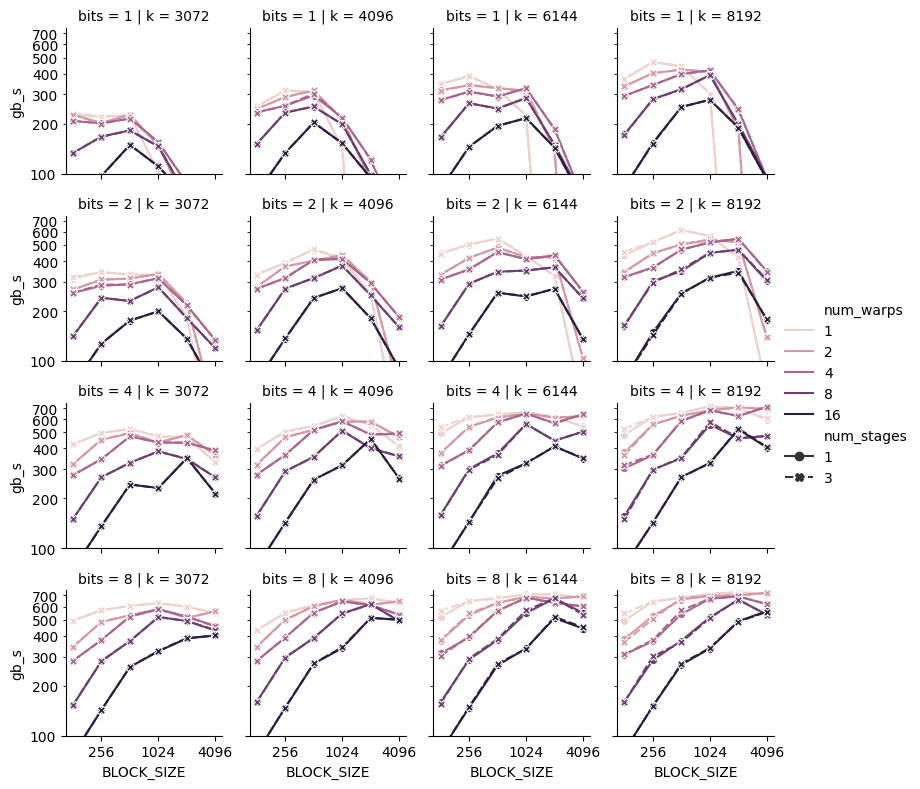

In [37]:
g = sns.relplot(data=df, y="gb_s", row="bits", col="k", x="BLOCK_SIZE", hue="num_warps", style="num_stages",
                hue_norm=matplotlib.colors.LogNorm(), kind="line", markers=True, height=2,
                facet_kws=dict(sharey="row"))
for ax in g.axes.flatten():
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter("{x:.0f}")
    ax.yaxis.set_minor_formatter("{x:.0f}")
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.set_ylim((100, 750))

## `mm_lut8`

In [50]:
block_sizes = [8, 16, 32, 64, 128, 256, 512]
df = sweep_benchmarks_df(
    bench.BENCHMARKS["mm_lut8"], bench.kernel__mm_lut,
    configs=generate_configs(
        BLOCK_SIZE_M=block_sizes,
        BLOCK_SIZE_N=block_sizes,
        BLOCK_SIZE_K=block_sizes,
        GROUP_SIZE_M=[8],
        num_stages=[1],  # consistently best
        num_warps=[2, 4, 8],
        # large blocks are too slow to compile
        _filter=lambda c: c["BLOCK_SIZE_M"] * c["BLOCK_SIZE_N"] * c["BLOCK_SIZE_K"] <= 2**17 and c["BLOCK_SIZE_K"] >= 64,
    ),
    settings=[
        bench.Settings(m, dim, dim, g=64, bits=bits, copies=100, reps=100)
        for bits in bits_range
        for m in batch_sizes
        for dim in [4096]  # model_dims
    ],
)

  0%|          | 0/1872 [00:00<?, ?it/s, {'m': 16, 'k': 4096, 'n': 4096, 'g': 64, 'bits': 1, 'copies': 100, 'reps': 100} {'BLOCK_SIZE_M': 8, 'BLOCK_SIZE_N': 8, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8, 'num_warps': 4, 'num_ctas': 1, 'num_stages': 1}]

100%|██████████| 1872/1872 [08:04<00:00,  3.87it/s, {'m': 256, 'k': 4096, 'n': 4096, 'g': 64, 'bits': 8, 'copies': 100, 'reps': 100} {'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 8, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8, 'num_warps': 8, 'num_ctas': 1, 'num_stages': 1}] 


In [61]:
df.groupby(["m", "bits"]).apply(lambda d: d.loc[d["tflops"].idxmax()], include_groups=False)[["BLOCK_SIZE_M", "BLOCK_SIZE_N", "BLOCK_SIZE_K", "num_warps", "tflops"]]

BLOCK_SIZE_M  BLOCK_SIZE_N  BLOCK_SIZE_K  num_warps     tflops
m   bits                                                                
16  1               16            16           128          4  32.768001
    2               16            16           256          4  30.218328
    4               16             8           256          2  24.579841
    8               16            16           512          4  17.178506
64  1               16            32            64          2  50.594739
    2               16            32           128          2  48.455454
    4               16            32           256          2  45.709503
    8               32            16           256          2  37.536281
256 1               16            32            64          2  54.985633
    2               32            32            64          2  55.290060
    4               32            32           128          2  53.143117
    8               64            32            64          2  61.159288

In [ ]:
config_cols = ['BLOCK_SIZE_M', 'BLOCK_SIZE_N', 'BLOCK_SIZE_K', 'num_warps']
df_temp = df.copy()
df_temp['config_key'] = df_temp[config_cols].apply(tuple, axis=1)
best_by_config = {
    config: group.groupby(['m', 'bits'])['tflops'].max().to_dict()
    for config, group in df_temp.groupby('config_key')
}
group_keys = sorted(df_temp.groupby(['m', 'bits']).size().index.tolist())

best_total = -1.0
best_combo = None
for combo in itertools.combinations(best_by_config, 3):
    total = torch.tensor([
        max(best_by_config[c].get(key, 0) for c in combo)
        for key in group_keys
    ]).prod().item()
    if total > best_total:
        best_total = total
        best_combo = combo

best_df = pd.DataFrame(best_combo, columns=config_cols)
print('max total tflops:', best_total)
best_df

max total tflops: 4.912198489217171e+18


,BLOCK_SIZE_M,BLOCK_SIZE_N,BLOCK_SIZE_K,num_warps
0,16,16,256,4
1,16,32,64,2
2,32,16,256,2


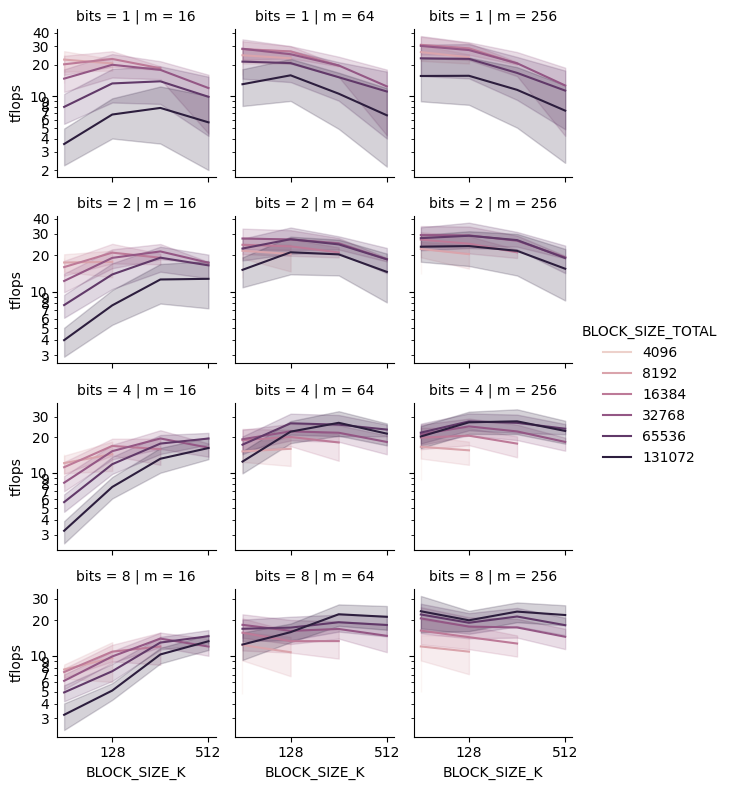

In [70]:
g = sns.relplot(data=df.pipe(lambda d: d.assign(BLOCK_SIZE_TOTAL=d["BLOCK_SIZE_M"] * d["BLOCK_SIZE_N"] * d["BLOCK_SIZE_K"])),
                y="tflops", row="bits", col="m", x="BLOCK_SIZE_K", hue="BLOCK_SIZE_TOTAL",
                hue_norm=matplotlib.colors.LogNorm(), kind="line", markers=True, height=2,
                facet_kws=dict(sharey="row"))
for ax in g.axes.flatten():
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter("{x:.0f}")
    ax.yaxis.set_minor_formatter("{x:.0f}")
    ax.xaxis.set_major_formatter("{x:.0f}")